In [1]:
import torch
from Define_Model.ResNet import ThinResNet
import numpy as np
import kaldi_io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rc('font', family='Times New Roman')


In [2]:
model = ThinResNet(resnet_size=34, block_type='None', channels=[16, 32, 64, 128],
                 input_len=300, inst_norm=False, input_dim=161, sr=16000, input_norm='Mean',
                 kernel_size=5, stride=2, padding=2, dropout_p=0.0, exp=False, filter_fix=False,
                 feat_dim=64, num_classes=1211, embedding_size=128, fast=False, time_dim=1, avg_size=4,
                 alpha=0, encoder_type='STAP', )

ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/ThinResNet34/vox1/spect_egs_mean/soft/STAP_em128_alpha0_wde4/checkpoint_50.pth')
model.load_state_dict(ckp['state_dict'][0])

# print(list(ckp['state_dict'][0].keys()))
all_layers = []
for name, m in model.named_modules():
    all_layers.append(name)
    
print(all_layers)

# module = model.layer4[0].bn2
# b = - (module.running_mean * module.weight / torch.sqrt(module.running_var + module.eps)) + module.bias
# b.data.shape

['', 'inst_layer', 'conv1', 'bn1', 'relu', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.2', 'layer2.2.conv1', 'layer2.2.bn1', 'layer2.2.relu', 'layer2.2.conv2', 'layer2.2.bn2', 'layer2.3', 'layer2.3.conv1', 'layer2.3.bn1', 'layer2.3.relu', 'layer2.3.conv2', 'layer2.3.bn2', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'laye

/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
out_feature_grads = []
in_feature_grads = []

def extract_layer_bias(module):
    # extract bias of each layer

    # for batchnorm, the overall "bias" is different
    # from batchnorm bias parameter.
    # Let m -> running mean, s -> running std
    # Let w -> BN weights, b -> BN bias
    # Then, ((x - m)/s)*w + b = x*w/s + (- m*w/s + b)
    # Thus (-m*w/s + b) is the effective bias of batchnorm
#     print(type(m))
    if isinstance(module, torch.nn.BatchNorm2d):
#         print('bn2')
        b = - (module.running_mean * module.weight
                / torch.sqrt(module.running_var + module.eps)) + module.bias
        return b.data
    elif module.bias is None:
        return None
    else:
        return module.bias.data
    
def _extract_layer_grads(module, in_grad, out_grad):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    if not module.bias is None:
        in_feature_grads.append(in_grad[0])
        out_feature_grads.append(out_grad[0])
        
in_layer_feat = []
out_layer_feat = []
in_layer_grad = []
out_layer_grad = []

def _extract_layer_feat(module, input, output):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
#     if not module.bias is None:
    in_layer_feat.append(input[0])
    out_layer_feat.append(output[0])
    
    
def _extract_layer_grad(module, in_grad, out_grad):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    in_layer_grad.append(in_grad[0])
    out_layer_grad.append(out_grad[0])
        

In [4]:
cam_layers = ['conv1', 'layer1.2.conv2']
cam_layers = ['conv1', 'layer1.2.conv2', 'layer3.5.conv2', 'layer4.2.conv2']

bias_layers = []
biases = []
handlers = []

for name, m in model.named_modules():
    try:
        if name in cam_layers:
            handlers.append(m.register_forward_hook(_extract_layer_feat))
            handlers.append(m.register_backward_hook(_extract_layer_grad))
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        if not ('fc' in name or 'classifier' in name) : 
#             print(m)
            b = extract_layer_bias(m)
            if (b is not None): 
                biases.append(b)
                bias_layers.append(name)
                    
#                 biases.append(_extract_layer_bias(m))
#                 print("bias:", _extract_layer_bias(m))
                m.register_backward_hook(_extract_layer_grads)
#                     m.register_forward_hook(_extract_layer_feat)
    except Exception as e:
        continue

# for name, m in model.named_modules():
#     if not ('fc' in name or 'classifier' in name) : 
#         b = self._extract_layer_bias(m)
#         if (b is not None): 
#             biases.append(b)
#             bias_layers.append(name)
           
print(bias_layers)
print("The number of layers with biases: ", len(biases))

['conv1', 'bn1', 'layer1.0.bn1', 'layer1.0.bn2', 'layer1.1.bn1', 'layer1.1.bn2', 'layer1.2.bn1', 'layer1.2.bn2', 'layer2.0.bn1', 'layer2.0.bn2', 'layer2.0.downsample.1', 'layer2.1.bn1', 'layer2.1.bn2', 'layer2.2.bn1', 'layer2.2.bn2', 'layer2.3.bn1', 'layer2.3.bn2', 'layer3.0.bn1', 'layer3.0.bn2', 'layer3.0.downsample.1', 'layer3.1.bn1', 'layer3.1.bn2', 'layer3.2.bn1', 'layer3.2.bn2', 'layer3.3.bn1', 'layer3.3.bn2', 'layer3.4.bn1', 'layer3.4.bn2', 'layer3.5.bn1', 'layer3.5.bn2', 'layer4.0.bn1', 'layer4.0.bn2', 'layer4.0.downsample.1', 'layer4.1.bn1', 'layer4.1.bn2', 'layer4.2.bn1', 'layer4.2.bn2']
The number of layers with biases:  37


input shape:  torch.Size([1, 1, 468, 161])


([], <a list of 0 Text yticklabel objects>)

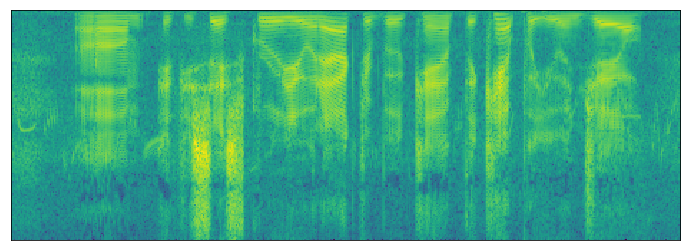

In [5]:

x1 = kaldi_io.read_mat('/home/work2020/yangwenhao/project/lstm_speaker_verification/data/vox1/spect/dev_log/Split18/0/dev_log_feat.0.ark:26')
x = torch.tensor(x1).reshape(1,1,-1,161).requires_grad_()
print("input shape: ", x.shape)

plt.figure(figsize=(12, 5))

im = plt.imshow(x1.transpose())
plt.xticks([])
plt.yticks([])
# plt.colorbar(im)  # 显示颜色标尺
# print(list(in_feature_grads.keys()))
# print(list(in_feature.keys()))

In [6]:
model.eval()
logits, feat = model(x)
logits[0].max().backward()
# print(feature_grads[0].shape)

In [79]:
print("Num of stored biases layers: ", len(bias_layers))
print("Num of stored gradient of biases layers: ", len(out_feature_grads))

ups = torch.nn.UpsamplingBilinear2d(size=(468, 161))
grad = x.grad.clamp_min(0)

input_gradient = (x.grad * x).clamp_min(0)

# grad cam
grad_cam = torch.zeros_like(x)
L = len(cam_layers)
assert len(out_layer_grad) == L, print(len(out_layer_grad))
for i,l in enumerate(out_layer_grad):
    
    weight = out_layer_grad[i].mean(dim=(2, 3), keepdim=True)
    weight /= weight.sum()
    feat = out_layer_feat[L-1-i]

    T = (feat * weight).sum(dim=1, keepdim=True).clamp_min(0)
    grad_cam += ups(T)
    

# grad cam ++
last_grad = out_layer_grad[0]
last_feat = out_layer_feat[-1]
first_derivative = logits[0].max().exp() * last_grad
alpha = last_grad.pow(2) / (2 * last_grad.pow(2) + (last_grad.pow(3) * last_feat).sum(dim=(2, 3), keepdim=True))
weight = alpha * (first_derivative.clamp_min_(0))
weight = weight.sum(dim=(2, 3), keepdim=True)
weight /= weight.sum()

grad_cam_pp = (last_feat * weight).sum(dim=1, keepdim=True)
grad_cam_pp -= grad_cam_pp.min()
grad_cam_pp /= grad_cam_pp.max()

grad_cam_pp = ups(grad_cam_pp)

# full grad
full_grad = input_gradient.clone()

L = len(bias_layers)
for i,l in enumerate(bias_layers):
    bias = biases[L-i-1]
    if len(bias.shape) == 1:
        bias = bias.reshape(1,-1,1,1)
    bias = bias.expand_as(out_feature_grads[i])
    
#     bias_grad = (out_feature_grads[i]*bias).sum(dim=1, keepdim=True)
    bias_grad = (out_feature_grads[i]*bias).mean(dim=1, keepdim=True)
#     bias_grad = (out_feature_grads[i]*bias).clamp_min(0).mean(dim=1, keepdim=True)
#     bias_grad /= bias_grad.max()
    full_grad += ups(bias_grad)
    
full_grad -= full_grad.min()
full_grad /= full_grad.max()

vis_grad = [x, grad, grad_cam, grad_cam_pp, full_grad]

Num of stored biases layers:  37
Num of stored gradient of biases layers:  37


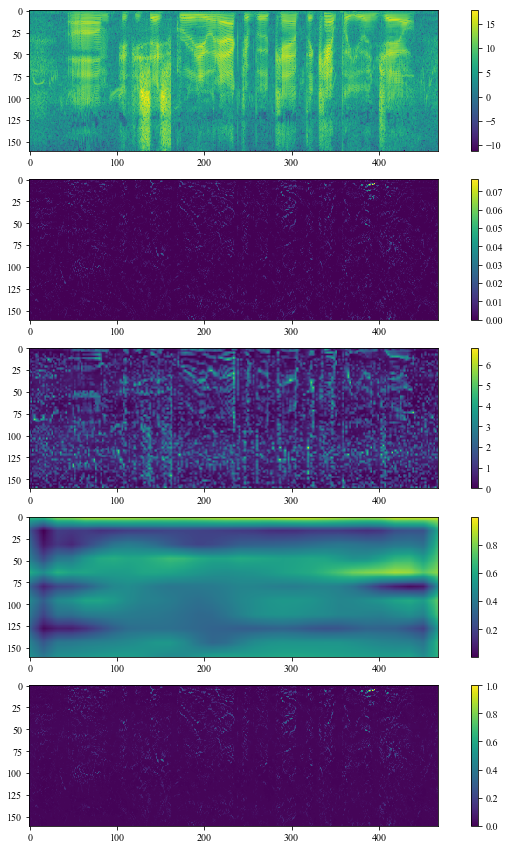

In [80]:
plt.figure(figsize=(12, 15))
# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)

for i in range(len(vis_grad)):
    ax = plt.subplot(len(vis_grad), 1, i+1)
    im = ax.imshow(vis_grad[i].squeeze().detach().numpy().transpose()) #, norm=norm)
    plt.colorbar(im)  # 显示颜色标尺


(468, 161)
(359, 161)


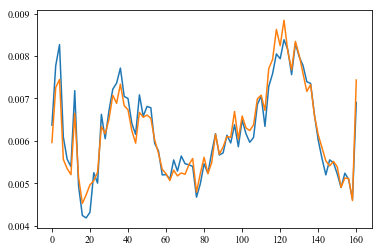

In [75]:
grad_plus = vis_grad[2].squeeze().detach().numpy()# .transpose()
grad_plus_time = grad_plus.mean(axis=1)
grad_plus_time_mean = grad_plus_time.mean()*0.8
print(grad_plus.shape)

freq_grad = grad_plus[np.where(grad_plus_time>grad_plus_time_mean)[0]]
print(freq_grad.shape)

freq_grad = freq_grad.mean(axis=0)

# .mean(axis=0)
# print(freq_grad.shape)
plt.plot(freq_grad/freq_grad.sum())

grad_plus_mean = grad_plus.mean(axis=0)
plt.plot(grad_plus_mean/grad_plus_mean.sum())

0.5341880341880342
0.6282051282051282
0.8739316239316239
0.6410256410256411


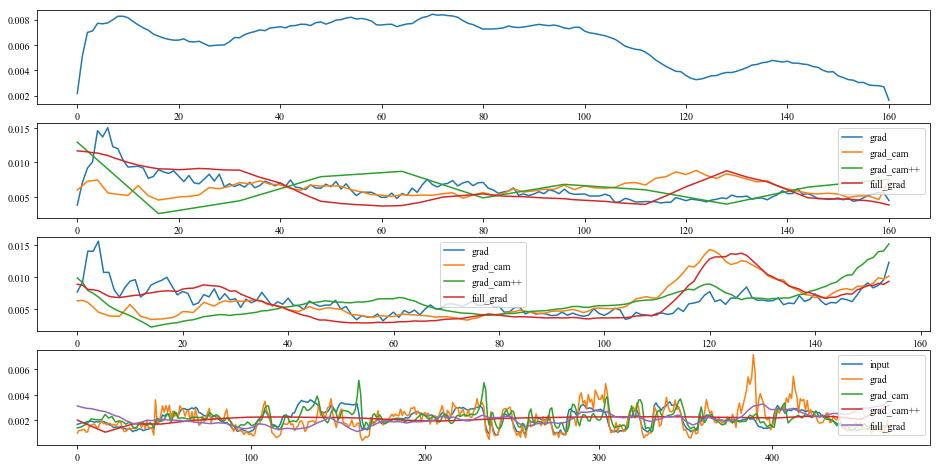

In [76]:
input_norm = vis_grad[0].squeeze().detach().numpy().mean(axis=0)[1:-2]
input_norm /= input_norm.sum()
def plot_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy().transpose().mean(axis=axis)
    this_grad /= this_grad.sum()
    plt.plot(this_grad)
    
def plot_part_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy()# .transpose()
    all_time = len(this_grad)
    grad_plus_time = this_grad.mean(axis=1)
    grad_plus_time_mean = grad_plus_time.mean()*0.9
    freq_grad = this_grad[np.where(grad_plus_time>grad_plus_time_mean)[0]]
    part_time = len(freq_grad)
    this_grad = freq_grad.mean(axis=0)[1:-2]
    print(part_time/all_time)
    this_grad /= input_norm
    this_grad /= this_grad.sum()
    
    plt.plot(this_grad[1:-2])

    


plt.figure(figsize=(16, 8))

plt.subplot(4,1,1)
plot_grad(vis_grad[0], 1)
    
plt.subplot(4,1,2)
for i in range(1, len(vis_grad)):
    plot_grad(vis_grad[i], 1)

plt.legend(['grad', 'grad_cam', 'grad_cam++', 'full_grad'])

plt.subplot(4,1,3)
for i in range(1, len(vis_grad)):
    plot_part_grad(vis_grad[i], 1)

plt.legend(['grad', 'grad_cam', 'grad_cam++', 'full_grad'])


# plt.subplot(5,1,4)
# plot_grad(vis_grad[0], 0)
    
plt.subplot(4,1,4)
for i in range(len(vis_grad)):
    plot_grad(vis_grad[i], 0)

plt.legend(['input', 'grad', 'grad_cam', 'grad_cam++', 'full_grad'])


In [22]:
im = plt.imshow(in_feature_grads['Conv2d'].squeeze().numpy().transpose())
plt.colorbar(im)  # 显示颜色标尺


TypeError: list indices must be integers or slices, not str

In [13]:
bias_gradient = b.reshape(1,-1,1,1).expand_as(in_feature_grads['BatchNorm2d'])*in_feature_grads['BatchNorm2d'].abs()
input_graident = (in_feature_grads['BatchNorm2d'] * in_feature['BatchNorm2d']).abs() # + bias_gradient

bias_gradient = bias_gradient.sum(dim=1, keepdim=True)
bias_gradient /= bias_gradient.max()

input_graident = input_graident.sum(dim=1, keepdim=True)
input_graident /= input_graident.max()



In [14]:
# input_grad* input + bias_gradient
# print(in_feature['BatchNorm2d'])


In [15]:
upsample = torch.nn.UpsamplingBilinear2d(size=(468, 161))
input_graident = upsample(input_graident)
bias_gradient = upsample(bias_gradient)

saliency_map = input_graident + bias_gradient

print(saliency_map.shape)

torch.Size([1, 1, 468, 161])


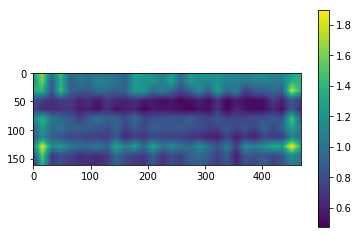

In [16]:
im = plt.imshow(saliency_map.squeeze().detach().numpy().transpose())
plt.colorbar(im)  # 显示颜色标尺


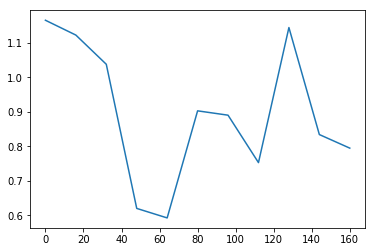

In [17]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=1))

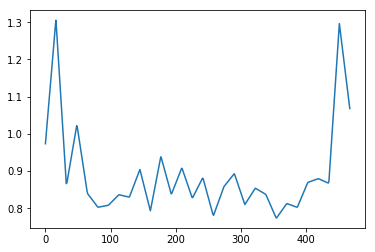

In [18]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=0))